# Embedding 활용 텍스트 분석

> imdb 영화 리뷰 데이터셋(영문)

## #01. 준비작업

### [1] 패키지 참조


In [41]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action="ignore")

from hossam.util import *
from hossam.plot import *
from hossam.tensor import *

from tensorflow.keras.preprocessing.sequence import pad_sequences

# 모듈을 사용하지 않고 순정 코드로 구현할 경우
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding, Flatten
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기

Tensorflow에 내장된 데이터가 있지만, 동일 데이터를 미리 엑셀로 저장 두었다.


In [42]:
origin = my_read_excel(
    "https://data.hossam.kr/tmdata/imdb.xlsx", categories=["sentiment"]
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49998 entries, 0 to 49997
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   sentiment  49998 non-null  category
 1   review     49998 non-null  object  
dtypes: category(1), object(1)
memory usage: 439.7+ KB
None

상위 5개 행
+----+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## #02. 데이터 전처리

### [1] 종속변수 라벨링


In [43]:
df = my_labelling(origin, 'sentiment')
my_pretty_table(df.head())

+-------------+---------+
| sentiment   |   label |
|-------------+---------|
| negative    |       0 |
| positive    |       1 |
+-------------+---------+
+----+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### [2] 문자열 전처리

* 축약형 문자열 처리
* 이메일 주소 제거
* HTML 태그 제거
* URL 제거
* 숫자 제거
* 특수문자 제거
* 불용어 제거

#### (1) 영어 불용어 목록


In [44]:
#stopwords = my_stopwords('en')
#stopwords[:10]

#### (2) 전처리 수행


In [45]:
%%time

df2 = my_text_data_preprocessing(df, 'review', rm_abbr=True, rm_email=True, 
                                 rm_html=True, rm_url=True, rm_num=True, rm_special=True)
my_pretty_table(df2.head())

+----+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### [3] 독립, 종속변수 분리


In [46]:
y = df2['sentiment']
x = df2['review']

### [4] 문자열 토큰화

#### (1) 전체 데이터에 대한 토큰화


In [47]:
%%time

tokenizer = my_tokenizer(x)
print(f'전체 단어수: {len(tokenizer.word_index)+1}')

token_set = tokenizer.texts_to_sequences(x)
print('토큰의 크기:', len(token_set))

i = tokenizer.texts_to_sequences(x.head(10))
for j in range(10):
    print(i[j].count(1))
    print(i[j])
    print('-'*30)

전체 단어수: 216474
토큰의 크기: 49998
0
[28, 5, 2, 82, 1878, 44, 1026, 12, 103, 146, 40, 3238, 380, 21, 55, 27, 3076, 30, 22, 200, 15, 11, 6, 570, 47, 558, 16, 7380, 90, 147, 12, 3162, 71, 43, 3238, 14, 91, 5388, 3, 14721, 134, 5, 561, 62, 276, 9, 200, 35, 2, 639, 139, 1678, 71, 11, 6, 13, 4, 119, 17, 2, 7982, 5583, 39, 11370, 11, 119, 2428, 58, 5797, 16, 5491, 7, 1414, 368, 39, 561, 91, 6, 3304, 9, 2, 339, 331, 5, 2, 60332, 6, 446, 3238, 15, 12, 6, 2, 11045, 335, 7, 2, 15320, 6647, 2478, 1021, 60333, 8, 2539, 1323, 24, 24316, 514, 33, 4578, 2434, 5, 2, 1158, 113, 31, 2, 6851, 23, 2876, 12466, 3, 393, 60334, 37, 16758, 6, 13, 308, 24, 2, 4915, 92, 514, 6, 332, 7, 82191, 8110, 39518, 14722, 5006, 7571, 2372, 3, 16759, 60335, 318, 8887, 7168, 13328, 3, 8357, 33516, 22, 111, 219, 19684, 48, 125, 2, 263, 1247, 5, 2, 119, 6, 640, 7, 2, 182, 12, 8, 253, 113, 82, 247, 48, 13, 2883, 789, 175, 1220, 4210, 17, 2413, 1058, 789, 1360, 789, 82192, 73, 13, 941, 178, 2, 90, 380, 10, 121, 196, 3162, 71, 15, 37

#### (2) 각 단어별 빈도수 확인

`(단어: 빈도수)` 형태의 튜플을 원소로 갖는 odict_list 타입 객체를 반환


In [48]:
bins = tokenizer.word_counts.items()
print(list(bins)[:5])

[('one', 50323), ('of', 288404), ('the', 650099), ('other', 17762), ('reviewers', 500)]


#### (3) 자주 등장하는 단어 수 계산


In [49]:
threshold = 30

total_cnt = len(tokenizer.word_index)

rare_cnt = 0

total_freq = 0

rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기:', total_cnt)
print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s' % (threshold, rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq) * 100)

vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합(vocabulary)의 크기: 216473
등장 빈도가 30번 미만인 희귀 단어의 수: 201154
단어 집합에서 희귀 단어의 비율: 92.92336688640154
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.968858700328982
단어 집합의 크기 : 15320


#### (4) 자주 등장하는 단어를 제외한 나머지 단어를 OOV로 처리하여 최종 토큰화 진행

`num_words` 를 설정하더라도 전체 단어수나 토큰의 크기에는 영향을 주지 않는다.


In [50]:
%%time

tokenizer2 = my_tokenizer(x, num_words=vocab_size)
print(f'전체 단어 수: {len(tokenizer2.word_index) + 1}')

token_set = tokenizer2.texts_to_sequences(x)
print('토큰의 크기:', len(token_set))

i = tokenizer2.texts_to_sequences(x.head(10))

for j in range(10):
    print(i[j].count(1))
    print(i[j])
    print('-' * 30)

전체 단어 수: 216474
토큰의 크기: 49998
16
[28, 5, 2, 82, 1878, 44, 1026, 12, 103, 146, 40, 3238, 380, 21, 55, 27, 3076, 30, 22, 200, 15, 11, 6, 570, 47, 558, 16, 7380, 90, 147, 12, 3162, 71, 43, 3238, 14, 91, 5388, 3, 14721, 134, 5, 561, 62, 276, 9, 200, 35, 2, 639, 139, 1678, 71, 11, 6, 13, 4, 119, 17, 2, 7982, 5583, 39, 11370, 11, 119, 2428, 58, 5797, 16, 5491, 7, 1414, 368, 39, 561, 91, 6, 3304, 9, 2, 339, 331, 5, 2, 1, 6, 446, 3238, 15, 12, 6, 2, 11045, 335, 7, 2, 1, 6647, 2478, 1021, 1, 8, 2539, 1323, 24, 1, 514, 33, 4578, 2434, 5, 2, 1158, 113, 31, 2, 6851, 23, 2876, 12466, 3, 393, 1, 37, 1, 6, 13, 308, 24, 2, 4915, 92, 514, 6, 332, 7, 1, 8110, 1, 14722, 5006, 7571, 2372, 3, 1, 1, 318, 8887, 7168, 13328, 3, 8357, 1, 22, 111, 219, 1, 48, 125, 2, 263, 1247, 5, 2, 119, 6, 640, 7, 2, 182, 12, 8, 253, 113, 82, 247, 48, 13, 2883, 789, 175, 1220, 4210, 17, 2413, 1058, 789, 1360, 789, 1, 73, 13, 941, 178, 2, 90, 380, 10, 121, 196, 3162, 71, 15, 37, 1519, 8, 14, 2131, 10, 76, 13, 125, 10, 14, 1496

#### (5) 토큰화 결과 길이가 0인 문장 찾기


In [51]:
drop_target_index = []

for i,v in enumerate(token_set):
    if len(v) < 1:
        drop_target_index.append(i)
        
print('길이가 0인 항목의 수: ', len(drop_target_index))

print('길이가 0인 항목의 인덱스 모음: ', drop_target_index)

길이가 0인 항목의 수:  0
길이가 0인 항목의 인덱스 모음:  []


#### (6) 토큰화 결과의 길이가 0인 항목 삭제하기

> 이 예제에서는 길이가 0인 항목이 없지만 코드의 패턴화를 위해 구현해 둔다.


In [52]:
token_set2 = np.asarray(token_set, dtype='object')

fill_token_set = np.delete(token_set2, drop_target_index, axis=0)

label_set = np.delete(y, drop_target_index, axis=0)

print('독립변수(덧글) 데이터 수: ',len(fill_token_set))
print('종속변수(레이블) 데이터 수: ',len(label_set))


독립변수(덧글) 데이터 수:  49998
종속변수(레이블) 데이터 수:  49998


## #04. 탐색적 데이터 분석

### [1] 각 문장별로 몇 개의 단어를 포함하고 있는지 측정


In [53]:
word_counts= []

for s in fill_token_set:
    word_counts.append(len(s))
    
count_df = DataFrame({'count':word_counts})
count_df

,count
0,307
1,156
2,163
3,131
4,222
...,...
49993,197
49994,108
49995,226
49996,213


### [2] 리뷰 중 가장 많은 단어를 사용한 리뷰와 가장 적은 단어를 사용한 리뷰의 단어 수


In [54]:
max_word_count = max(word_counts)
min_word_count = min(word_counts)
print('가장 많은 단어를 사용하는 문장의 단어 수:', max_word_count)
print('가장 적은 단어를 사용하는 문장의 단어 수:', min_word_count)

가장 많은 단어를 사용하는 문장의 단어 수: 2454
가장 적은 단어를 사용하는 문장의 단어 수: 4


## #05. 학습 모형 적합

### [1] 패딩처리

최대 단어수를 갖고 있는 문장을 기준으로 그보다 적은 단어를 갖고 있는 문장은 최대 단어수와 동일해 질 때까지 0으로 채워넣는다.


In [55]:
max_word_count = max(word_counts)
pad_token_set = pad_sequences(fill_token_set, maxlen=max_word_count)
print('After pad_sequences: ', len(pad_token_set[0]), len(pad_token_set[1]))
print(pad_token_set[0])

After pad_sequences:  2454 2454
[   0    0    0 ...  122 3893  482]


### [2] 데이터 분할


In [56]:
x_train, x_test, y_train, y_test = my_train_test_split(pad_token_set, ydata=label_set)

print('훈련용 데이터셋 크기: %s, 검증용 데이터셋 크기: %s' % (x_train.shape, x_test.shape))

print('훈련용 레이블 크기: %s, 검증용 레이블 크기: %s' % (y_train.shape, y_test.shape))

훈련용 데이터셋 크기: (39998, 2454), 검증용 데이터셋 크기: (10000, 2454)
훈련용 레이블 크기: (39998,), 검증용 레이블 크기: (10000,)


### [3] 모델 생성

1. input_dim 인자는 학습 데이터셋에서 사용한 단어의 개수(vocab_size)
2. output_dim 인자는 임베딩 벡터의 크기(32)
    - output_dim의 크기는 input_dim보다 작은 값 중에서 설정
    - 이와 같이 인자를 설정하고 나면 Embedding층은 (None, vocab_size, 32) 형태의 출력을 가지게 된다.
3. input_length인자는 Flatten 층을 사용하기 위해 전달.
4. 결국은 문장을 학습하여 긍정, 부정 여부를 판단하는 것이므로 이진분류분석에 속한다.


{'type': 'embedding', 'input_dim': 15320, 'output_dim': 32, 'input_length': 2454}
{'type': 'flatten'}
{'type': 'dense', 'units': 1, 'activation': 'sigmoid'}


0epoch [00:00, ?epoch/s]

+-------+----------+----------+
|       |     loss |      acc |
|-------+----------+----------|
| train | 0.178684 | 0.938672 |
| test  | 0.261003 |   0.8945 |
+-------+----------+----------+


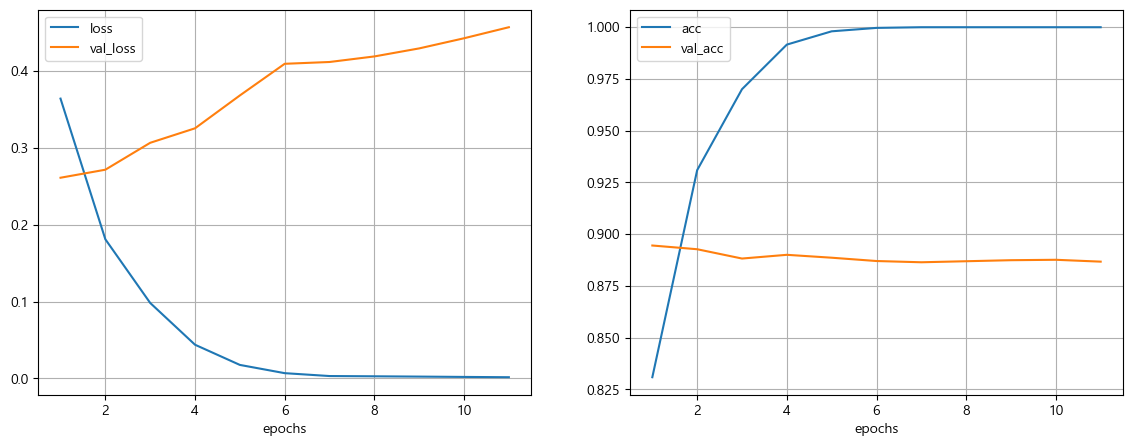

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2454, 32)          490240    
                                                                 
 flatten_1 (Flatten)         (None, 78528)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 78529     
                                                                 
Total params: 568769 (2.17 MB)
Trainable params: 568769 (2.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
model = my_tf(
    x_train = x_train,
    y_train = y_train,
    x_test = x_test,
    y_test = y_test,
    layer=[
        dict(type='embedding', input_dim=vocab_size, output_dim=32,
             input_length=max_word_count),
        dict(type='flatten'),
        dict(type='dense', units=1, activation='sigmoid')
    ],
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

model.summary()

## #06. 학습 결과 적용

### [1] 검증 데이터에 대한 예측 결과 산정


In [58]:
result = model.predict(x_test)
data_count, case_count = result.shape
print('%d개의 검증 데이터가 %d개의 경우의 수를 갖는다.' % (data_count, case_count))
result

313/313 [==============================] - 1s 3ms/step
10000개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([[0.869334  ],
       [0.03399948],
       [0.9994245 ],
       ...,
       [0.01802653],
       [0.0125009 ],
       [0.12276395]], dtype=float32)

### [2] 예측 결과를 1차원 배열로 변환


In [59]:
f_results = result.flatten()
f_results = np.round(f_results, 0)
f_results

array([1., 0., 1., ..., 0., 0., 0.], dtype=float32)

### [3] 오차행렬


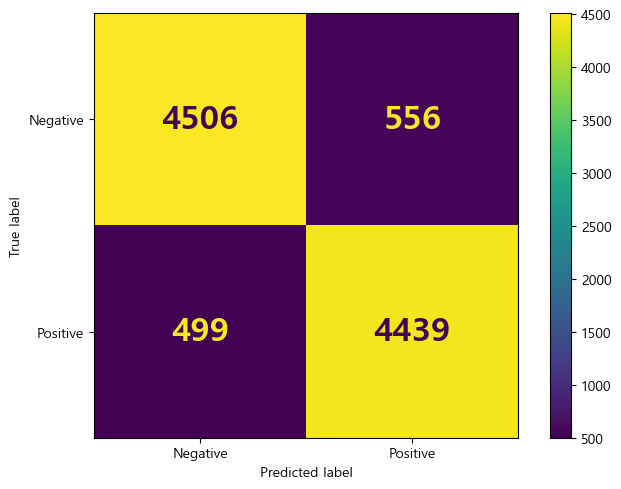

In [60]:
my_confusion_matrix(y_test, f_results, figsize=(7, 5))

## #07. 학습 결과 활용

### [1] 임의의 문장


In [61]:
review = [
    "I had a lot of fun watching it.",
    "I didn't notice how time passed.",
    "I was happy the whole time I watched it.",
    "worst movie",
    "such a boring movie",
]

### [2] 문자열 전처리


In [62]:
review_pre = [my_text_preprocessing(x, stopwords=stopwords) for x in review]
review_pre

['I lot fun watching it',
 'I notice time passed',
 'I happy whole time I watched it',
 'worst movie',
 'boring movie']

### [3] 토큰화


In [63]:
tokenizer2 = my_tokenizer(review_pre, num_words=vocab_size)
print(f'전체 단어수: {len(tokenizer2.word_index) + 1}')

token_set = tokenizer2.texts_to_sequences(review_pre)
print('토큰의 크기 :', len(token_set))

전체 단어수: 16
토큰의 크기 : 5


### [4] 패딩


In [64]:
pad_token_set = pad_sequences(token_set, maxlen=max_word_count)
pad_token_set

array([[ 0,  0,  0, ...,  7,  8,  3],
       [ 0,  0,  0, ...,  9,  4, 10],
       [ 0,  0,  0, ...,  2, 13,  3],
       [ 0,  0,  0, ...,  0, 14,  5],
       [ 0,  0,  0, ...,  0, 15,  5]])

### [5] 예측값 생성


In [65]:
f_results = model.predict(pad_token_set)
data_count, case_count = f_results.shape
print('%d개의 검증데이터가 %d개의 경우의 수를 갖는다.' % (data_count, case_count))
f_results

1/1 [==============================] - 0s 16ms/step
5개의 검증데이터가 1개의 경우의 수를 갖는다.


array([[0.54769015],
       [0.4924914 ],
       [0.4463735 ],
       [0.41881365],
       [0.43973833]], dtype=float32)

### [6] 결과 판정


In [66]:
f_results = np.round(f_results.flatten(), 0)

for i, v in enumerate(review):
    k = '긍정' if f_results[i] == 1 else '부정'
    print(f'[{k}] {v}')

[긍정] I had a lot of fun watching it.
[부정] I didn't notice how time passed.
[부정] I was happy the whole time I watched it.
[부정] worst movie
[부정] such a boring movie
